In [12]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [32]:
import numpy as np
import matplotlib
import time
import pickle
from pprint import pprint
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

from package.plots import diagnostic_plot, plot, lens_plot
from package.helpers.lens import Lens
from package.helpers import pyhalo

plt.style.use(f'{repo_path}/package/mplstyle/science.mplstyle')

In [14]:
array_dir = os.path.join(repo_path, 'output', 'arrays', 'skypy_test')
data_dir = os.path.join('/data','bwedig', 'roman-population', 'data')
figure_dir = os.path.join(repo_path, 'figures')

In [15]:
csv_path = os.path.join(data_dir, 'dictparaggln_Area00000010.csv')
df = pd.read_csv(csv_path)

In [16]:
index = 3
row = df.iloc[index]

lens = Lens(z_lens=row['redslens'], 
            z_source=row['redssour'], 
            sigma_v=row['velodisp'], 
            lens_x=row['xposlens'], 
            lens_y=row['yposlens'], 
            source_x=row['xpossour'], 
            source_y=row['ypossour'], 
            mag_lens=row['magtlensF106'], 
            mag_source=row['magtsourF106'])

# add CDM subhalos
lens.add_subhalos(*pyhalo.generate_CDM_halos(lens.z_lens, lens.z_source))

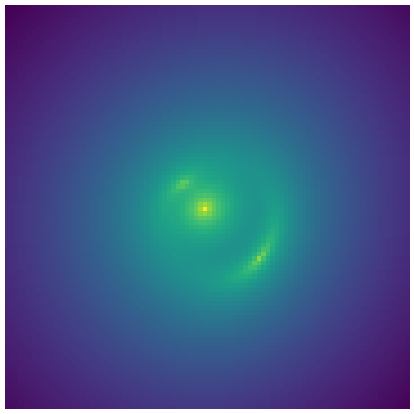

In [26]:
model = lens.get_array(num_pix=90, side=10.)

plt.imshow(np.log10(model), cmap='viridis')
plt.axis('off')

plt.savefig(os.path.join(figure_dir, 'sample_lenstronomy.png'))
plt.show()

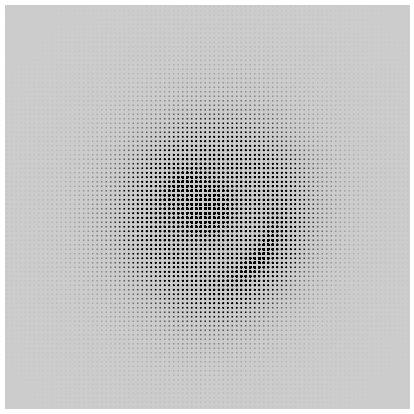

In [36]:
oversample_factor = 3
oversample_grid = np.zeros((model.shape[0] * oversample_factor, model.shape[1] * oversample_factor))
flattened_model = model.flatten()

k = 0

for i, row in enumerate(oversample_grid):
    for j, _ in enumerate(row):
        if not (i % oversample_factor) - 1 == 0:
            continue
        if (j % oversample_factor) - 1 == 0:
            oversample_grid[i][j] = flattened_model[k]
            k += 1

percentile = np.percentile(oversample_grid, 98)
vmin = -0.25 * percentile
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=percentile)

plt.imshow(oversample_grid, cmap='binary', norm=norm)
plt.axis('off')

plt.savefig(os.path.join(figure_dir, 'sample_phonions.png'))
plt.show()

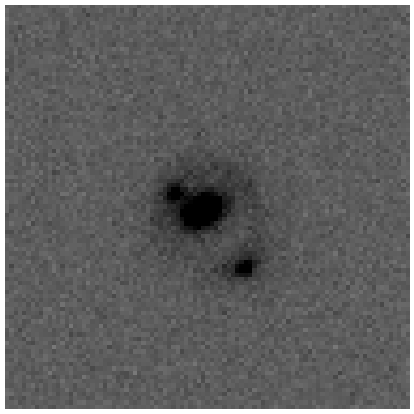

In [43]:
image_filepath = glob(array_dir + f'/skypy_output_*0{index}.npy')[0]
pandeia_image = np.load(image_filepath)

percentile = np.percentile(pandeia_image, 99.25)
vmin = -0.25 * percentile
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=percentile)

plt.imshow(pandeia_image, cmap='binary', norm=norm)
plt.axis('off')

plt.savefig(os.path.join(figure_dir, 'sample_pandeia.png'))
plt.show()

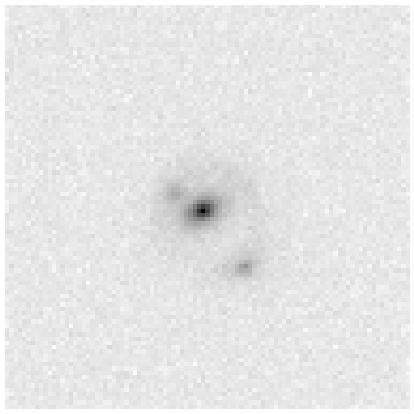

In [42]:
plt.imshow(np.log10(pandeia_image), cmap='binary')
plt.axis('off')

plt.savefig(os.path.join(figure_dir, 'sample_pandeia.png'))
plt.show()